# Проект e-commerce

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (10 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (7 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Выполните когортный анализ пользователей. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. Для визуализации когортной таблицы рекомендуем использовать пример из 8-го урока python, раздел “Стильный урок”, степ 5. (15 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (23 балла)

**Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.** 

**Файлы:**  

1) **olist_customers_datase.csv** — таблица с уникальными идентификаторами пользователей:  
- customer_id — позаказный идентификатор пользователя 
- customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)  
- customer_zip_code_prefix —  почтовый индекс пользователя
- customer_city —  город доставки пользователя
- customer_state —  штат доставки пользователя

2) **olist_orders_dataset.csv** —  таблица заказов:
- order_id —  уникальный идентификатор заказа (номер чека)
- customer_id —  позаказный идентификатор пользователя
- order_status —  статус заказа
- order_purchase_timestamp —  время создания заказа
- order_approved_at —  время подтверждения оплаты заказа
- order_delivered_carrier_date —  время передачи заказа в логистическую службу
- order_delivered_customer_date —  время доставки заказа
- order_estimated_delivery_date —  обещанная дата доставки

3) **olist_order_items_dataset.csv** —  товарные позиции, входящие в заказы
- order_id —  уникальный идентификатор заказа (номер чека)
- order_item_id —  идентификатор товара внутри одного заказа
- product_id —  id товара (аналог штрихкода)
- seller_id — id производителя товара
- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- price —  цена за единицу товара
- freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице **olist_orders_dataset:**

- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta 

In [2]:
olist_customers_dataset = pd.read_csv('olist_customers_dataset.csv')
olist_customers_dataset.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [3]:
olist_orders_dataset = pd.read_csv('olist_orders_dataset.csv')
olist_orders_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [4]:
olist_order_items_dataset = pd.read_csv('olist_order_items_dataset.csv')
olist_order_items_dataset.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [5]:
#Знакомство с нашими данными: кол-во строк и столбцов, типы переменных, а так же наличие пропущенных значений

olist_customers_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [6]:
olist_customers_dataset.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [9]:
olist_orders_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [10]:
olist_orders_dataset.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [11]:
olist_order_items_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [12]:
olist_order_items_dataset.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [13]:
#Смотрим на пропущенные значения
missing_rows = olist_orders_dataset[olist_orders_dataset.isnull().any(axis=1)]

In [14]:
missing_rows

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaN,NaN,2018-02-06 00:00:00
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00


In [15]:
missing_rows.groupby('order_status', as_index=False).agg({'order_id': 'count'})

,order_status,order_id
0,approved,2
1,canceled,619
2,created,5
3,delivered,23
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [16]:
missing_rows.query("order_status == 'delivered'").sort_values(by='order_purchase_timestamp')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaN,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01 00:00:00
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaN,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16 00:00:00
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaN,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20 00:00:00
72407,3c0b8706b065f9919d0505d3b3343881,d85919cb3c0529589c6fa617f5f43281,delivered,2017-02-17 15:53:27,NaN,2017-02-22 11:31:30,2017-03-03 11:47:47,2017-03-23 00:00:00
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaN,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20 00:00:00
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaN,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22 00:00:00
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaN,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21 00:00:00
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaN,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17 00:00:00
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaN,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17 00:00:00
63052,51eb2eebd5d76a24625b31c33dd41449,07a2a7e0f63fd8cb757ed77d4245623c,delivered,2017-02-18 15:52:27,NaN,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29 00:00:00


In [15]:
#Все пропущенные значения - даты. Пропущенные даты могут значить,что заказ не был доставлен по тем или иным причинам
#(отмена заказа, отсутствие товара, неоплата счета). Так же есть пропущенные значения в доставленных заказах, 
# что скорее всего может говорить об ошибках в системе или в процессе обработки заказа, 
# из-за которых значение подтверждения оплаты и времени доставки не было корректно заполнено.

In [17]:
# Преобразуем столбцы с датами в формат datetime

olist_orders_dataset[['order_purchase_timestamp',\
                      'order_approved_at',\
                      'order_delivered_carrier_date',\
                      'order_delivered_customer_date',\
                      'order_estimated_delivery_date']] = olist_orders_dataset[['order_purchase_timestamp',\
                                                                                'order_approved_at',\
                                                                                'order_delivered_carrier_date',\
                                                                                'order_delivered_customer_date',\
                                                                                'order_estimated_delivery_date']]\
                                                                                .apply(pd.to_datetime)

In [18]:
olist_orders_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


## Шаг 1

Сколько у нас пользователей, которые совершили покупку только один раз?

In [18]:
# Уникальный идентификатор пользователя 'customer_unique_id' позволяет однозначно идентифицировать каждого 
# пользователя в системе и избежать учета повторных покупок от одного и того же пользователя.
# Чтобы посчитать кол-во пользователей, совершивших одну покупку, нужно объединить 1 и 2 таблицы.

In [19]:
merged_df = pd.merge(olist_customers_dataset, olist_orders_dataset, on='customer_id')

In [20]:
# Отберем только завершенные покупки
filtered_df = merged_df.query("order_status == 'delivered'")

In [21]:
# Посчитаем кол-во завершенных заказов для каждого customer_unique_id и отсортируем по убыванию
unique_orders_by_user = filtered_df.groupby('customer_unique_id', as_index=False)\
                                   .agg({'order_id': 'count'})\
                                   .rename(columns={'order_id': 'unique_orders'})\
                                   .sort_values(by='unique_orders', ascending=False)

In [22]:
unique_orders_by_user.head()

,customer_unique_id,unique_orders
51431,8d50f5eadf50201ccdcedfb9e2ac8455,15
22779,3e43e6105506432c953e165fb2acf44c,9
36706,6469f99c1f9dfae7733b25662e7f1782,7
73921,ca77025e7201e3b30c44b472ff346268,7
10060,1b6c7548a2a1f9037c1fd3ddfed95f33,7


In [23]:
# Посчитаем кол-во пользователей, которые совершили покупку только один раз
number_with_one_purchase = unique_orders_by_user.query("unique_orders == 1").shape[0]

In [24]:
print(f"Количество пользователей, которые совершили покупку только один раз равно {number_with_one_purchase}")

Количество пользователей, которые совершили покупку только один раз равно 90557


## Шаг 2

Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [25]:
# К недоставленным заказам относятся заказы, имеющие статус "canceled" (отменен) и статус "unavailable" (недоступен).
failed_orders = olist_orders_dataset.query('order_status == "canceled" or order_status == "unavailable"')

In [26]:
# Находим первую и последнюю даты в столбце
first_date = olist_orders_dataset['order_purchase_timestamp'].min()
last_date = olist_orders_dataset['order_purchase_timestamp'].max()

In [27]:
# Вычисляем количество месяцев между первой и последней датой
num_months = (last_date.year - first_date.year) * 12 + last_date.month - first_date.month

In [28]:
failed_orders = failed_orders.groupby('order_status', as_index=False).agg({'order_id': 'count'}).rename(columns={'order_id': 'fail_orders'})

In [29]:
failed_orders

,order_status,fail_orders
0,canceled,625
1,unavailable,609


In [36]:
# Определим число заказов, которое в среднем не доставляется каждый месяц
avg_cancellations_by_month = failed_orders['fail_orders'].sum() / num_months
avg_cancellations_by_month

49.36

In [31]:
#Определим, сколько заказов в месяц в среднем не доставляется по разным причинам
failed_orders['fail_orders_by_month'] = failed_orders['fail_orders'] / num_months

In [32]:
failed_orders = failed_orders.sort_values(by='fail_orders_by_month', ascending=False)

In [37]:
failed_orders

,order_status,fail_orders,fail_orders_by_month
0,canceled,625,25.00
1,unavailable,609,24.36


В среднем в месяц не доставляется 49,36 заказов:

по причине того, что заказ недоступен: 25 заказов
по причине того, что заказ отменен: 24,36 заказа

## Шаг 3

По каждому товару определить, в какой день недели товар чаще всего покупается.  

In [39]:
olist_order_items_dataset.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [36]:
# Чтобы узнать дату покупки каждого товара, объединим таблицы с заказами и товарами в этих заказах.

In [66]:
order_product_merge = pd.merge(olist_order_items_dataset, olist_orders_dataset, on='order_id')

In [67]:
# Фильтруем данные по статусу заказа
order_product_merge = order_product_merge.query('order_status == ["processing", "shipped", "delivered"]')

In [68]:
# Добавим столбец с днем недели
order_product_merge['day_of_week'] = order_product_merge['order_purchase_timestamp'].dt.day_name()

In [70]:
 # Сгруппируем данные по 'product_id' и 'day_of_week' и посчитаем общее число 'order_item_id'

product_id_per_day = order_product_merge.groupby(['product_id', 'day_of_week'], as_index=False).agg({'order_item_id': 'count'})

In [72]:
# Находим индекс строки с максимальным значением 'order_item_id' для каждого 'product_id'
idx = product_id_per_day.groupby('product_id')['order_item_id'].idxmax()

In [74]:
# Фильтруем данные по найденным индексам
result = product_id_per_day.loc[idx]

In [75]:
result.sort_values(by='order_item_id', ascending=False) 

,product_id,day_of_week,order_item_id
15766,422879e10f46682990de24d770e7f83d,Wednesday,93
36178,99a4788cb24856965c36a24e339b6058,Monday,92
40679,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
19944,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
13422,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...
23460,62b07aff118f62756ee579afeedc3eb0,Thursday,1
23459,62ae6a8f5789aec14529a277c7516def,Sunday,1
23453,62abef05dddbd149514e4339c84f7d7d,Sunday,1
23451,62a6991adbb1e60f5c03a77fae5568ff,Monday,1


## Шаг 4

Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов)

In [45]:
#Вернемся к объединенному датафрейму из первого задания
merged_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [46]:
# Возьмем только заказы со статусом delivered
user_purchases = merged_df.query("order_status == 'delivered'")

In [47]:
# Рассчитываем количество дней в каждом месяце
user_purchases['days_in_month'] = user_purchases['order_purchase_timestamp'].dt.days_in_month

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [48]:
user_purchases

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,days_in_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,31
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,31
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,31
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,31
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,30
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,30
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,30
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,30


In [49]:
# Рассчитываем количество недель в каждом месяце
user_purchases['weeks_in_month'] = user_purchases['days_in_month'] / 7

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
user_purchases

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,days_in_month,weeks_in_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,31,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,31,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,31,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,31,4.428571
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,31,4.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,30,4.285714
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,30,4.285714
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,30,4.285714
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,30,4.285714


In [51]:
# Группируем данные по пользователю, месяцу и неделе, считаем общее количество покупок
grouped_data = user_purchases.groupby(['customer_unique_id', user_purchases['order_purchase_timestamp'].dt.to_period('M'), 'weeks_in_month']).agg({'order_id': 'count'}).reset_index()

In [52]:
# Делим общее количество покупок на количество недель для каждого месяца
grouped_data['avg_orders_per_week'] = grouped_data['order_id'] / grouped_data['weeks_in_month']

In [53]:
grouped_data

,customer_unique_id,order_purchase_timestamp,weeks_in_month,order_id,avg_orders_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,4.428571,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.285714,1,0.233333
...,...,...,...,...,...
95189,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,4.285714,1,0.233333
95190,fffea47cd6d3cc0a88bd621562a9d061,2017-12,4.428571,1,0.225806
95191,ffff371b4d645b6ecea244b27531430a,2017-02,4.000000,1,0.250000
95192,ffff5962728ec6157033ef9805bacc48,2018-05,4.428571,1,0.225806


In [54]:
# Посчитаем среднее число покупок в месяц для каждого пользователя
grouped_data['avg_orders_per_week'].mean()

0.23329252250243465

## Шаг 5

Выполните когортный анализ пользователей. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц.

In [76]:
#Вернемся к объединенному датафрейму merged_df из предыдущих заданий и посмотрим на минимальную и максимальную даты
merged_df['order_purchase_timestamp'].agg(['min', 'max'])

min   2016-09-04 21:15:19
max   2018-10-17 17:30:18
Name: order_purchase_timestamp, dtype: datetime64[ns]

In [77]:
#Данные с января по декабрь доступны только за 2017 год

In [108]:
data = merged_df.query('order_status == ["processing", "shipped", "delivered"]')

In [109]:
# Создадим когорту на основе месяца первой покупки
data['order_month'] = data['order_purchase_timestamp'].dt.to_period('M')
first_order = data.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index()
first_order['cohort'] = first_order['order_purchase_timestamp'].dt.to_period('M')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [110]:
orders = pd.merge(data, first_order[['customer_unique_id', 'cohort']], on='customer_unique_id')

In [ ]:
# Определим период с первой покупки

In [111]:
orders['cohort_period'] = (orders['order_purchase_timestamp'].dt.to_period('M') - orders['cohort']).apply(lambda x: x.n) 

In [112]:
# Подсчитываем количество пользователей, которые совершили хотя бы одну покупку в каждом месяце 
# после своей первой покупки
cohort_data = orders.groupby(['cohort', 'cohort_period']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index() 

In [113]:
# Отберем данные только за 2017 год
cohort_data = cohort_data[cohort_data['cohort'].dt.year == 2017]

In [114]:
cohort_pivot = cohort_data.pivot_table(index='cohort', columns='cohort_period', values='n_customers') 

In [115]:
#Расчет retention как отношение к первому месяцу когорты

cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

In [116]:
highest_retention = retention[3].idxmax()
highest_retention_value = retention.loc[highest_retention, 3]

In [117]:
print(f'Когорта с наивысшим retention на 3-й месяц: {highest_retention}')
print(f'Значение retention на 3-й месяц для этой когорты: {highest_retention_value:.2%}')

Когорта с наивысшим retention на 3-й месяц: 2017-05
Значение retention на 3-й месяц для этой когорты: 0.40%


In [118]:
ur_style = (retention.style
            .set_caption('User retention by cohort')
            .background_gradient(cmap='viridis')
            .highlight_null('white')
            .format("{:.2%}", na_rep=""))
ur_style

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
cohort,,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.41%,0.27%,0.14%,0.41%,0.14%,0.41%,0.14%,0.14%,,0.41%,0.14%,0.68%,0.41%,0.14%,0.14%,0.27%,0.41%,0.14%
2017-02,100.00%,0.24%,0.30%,0.12%,0.42%,0.12%,0.24%,0.18%,0.12%,0.18%,0.12%,0.30%,0.12%,0.18%,0.12%,0.06%,0.06%,0.24%,
2017-03,100.00%,0.51%,0.35%,0.39%,0.35%,0.16%,0.16%,0.31%,0.35%,0.08%,0.35%,0.12%,0.23%,0.12%,0.16%,0.23%,0.08%,0.16%,
2017-04,100.00%,0.61%,0.22%,0.17%,0.30%,0.26%,0.35%,0.30%,0.30%,0.17%,0.26%,0.09%,0.04%,0.04%,0.09%,0.09%,0.13%,,
2017-05,100.00%,0.48%,0.48%,0.40%,0.31%,0.34%,0.43%,0.14%,0.26%,0.26%,0.26%,0.34%,0.26%,0.03%,0.20%,0.23%,,,
2017-06,100.00%,0.45%,0.36%,0.39%,0.26%,0.36%,0.36%,0.23%,0.13%,0.23%,0.32%,0.32%,0.16%,0.13%,0.19%,,,,
2017-07,100.00%,0.52%,0.34%,0.24%,0.29%,0.21%,0.31%,0.10%,0.18%,0.26%,0.21%,0.29%,0.13%,0.26%,,,,,
2017-08,100.00%,0.68%,0.34%,0.27%,0.36%,0.54%,0.29%,0.27%,0.15%,0.15%,0.24%,0.19%,0.12%,,,,,,
2017-09,100.00%,0.69%,0.54%,0.30%,0.44%,0.22%,0.22%,0.25%,0.30%,0.17%,0.27%,0.07%,,,,,,,


## Шаг 6

Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 

In [172]:
# Используем наш объединенный датафрейм со всеми данными. Для начала сразу удалим пропуски и оставим нужные статусы
merged_df_1 = merged_df.dropna().query('order_status == ["processing", "shipped", "delivered"]')

In [173]:
# Посчитаем сумму каждого заказа в датасете olist_order_items_dataset 
df_order_amounts = olist_order_items_dataset.groupby('order_id', as_index=False).agg({'price': 'sum'})

In [174]:
 # Объединим датафрейм с уникальными пользователями merged_df и датафрейм с суммой для каждого заказа 

customers_orders_items_RFM = pd.merge(merged_df_1, df_order_amounts, on='order_id')

In [175]:
# Будем считать, что текущая дата - это максимальная дата покупки + 1 день
now = customers_orders_items_RFM.order_approved_at.max() + timedelta(days=1)

In [176]:
df_customer_orders_merged.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,price
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,124.99
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,230.00


In [177]:
# Найдем сразу все требуемые метрики
# R - время от последней покупки пользователя до текущей даты
# F - суммарное количество покупок у пользователя за всё время (покупка = заказ)
# M - сумма покупок за всё время
rfm = customers_orders_items_RFM.groupby('customer_unique_id', as_index = False) \
    .agg({'order_approved_at': lambda x:(now - x.max()).days, 'order_id': 'count', 'price': 'sum'}) \
    .rename(columns = {'order_approved_at': 'R', 'order_id': 'F', 'price': 'M'})

rfm

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00
...,...,...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,1570.00
93332,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89
93333,ffff371b4d645b6ecea244b27531430a,568,1,89.90
93334,ffff5962728ec6157033ef9805bacc48,119,1,115.00


In [ ]:
# Recency (Давность) — Как давно клиент совершил покупку?
# Frequency (Частота) — Как часто они совершают покупки?
# Monetary Value (Денежная ценность) — Сколько они тратят?

In [178]:
# Чтобы распределить пользователей по кластерам, используем квантили — составление частей на основе доступных значений 
# Нам нужно выявить явных "фаворитов" и "аутсайдеров", поэтому используем более крайние значения квантилей
quantiles = rfm.quantile(q=[0.1, 0.4, 0.7, 0.9])
quantiles

,R,F,M
0.1,42.0,1.0,25.98
0.4,177.0,1.0,69.90
0.7,312.0,1.0,139.00
0.9,465.0,1.0,279.99


In [179]:
# Из-за того, что клиенты в основном совершают 1 заказ, почти все квантили для метрики F получаются одинаковые
# Будем использовать собственную кластеризацию для всех метрик, с оглядкой на полученные квантили
rfm.F.value_counts()

1     90536
2      2572
3       181
4        28
5         9
6         5
7         3
15        1
9         1
Name: F, dtype: int64

In [180]:
# Посмотрим на экстремальные значения метрик 
rfm.describe()

,R,F,M
count,93336.000000,93336.000000,93336.000000
mean,237.486093,1.033417,141.621663
std,152.569986,0.209098,215.714143
min,1.000000,1.000000,0.850000
25%,114.000000,1.000000,47.650000
50%,219.000000,1.000000,89.700000
75%,346.000000,1.000000,154.692500
max,714.000000,15.000000,13440.000000


In [181]:
# Делим данные на сегменты при помощи pd.cut
rfm['R_categ'] = pd.cut(rfm.R, bins = [0, 32, 184, 367, 715], 
                                     labels = ['4', '3', '2', '1'])
rfm['F_categ'] = pd.cut(rfm.F, bins = [0, 1, 3, 6, 25], 
                                     labels = ['1', '2', '3', '4'])
rfm['M_categ'] = pd.cut(rfm.M, bins = [0, 20, 70, 140, 13450], 
                                     labels = ['1', '2', '3', '4'])

# Меняем тип данных на строковый
rfm['R_categ'] = rfm['R_categ'].astype(str)
rfm['F_categ'] = rfm['F_categ'].astype(str)
rfm['M_categ'] = rfm['M_categ'].astype(str)


# И соединяем оценку
rfm['RFM_score'] = rfm['R_categ'] + rfm['F_categ'] + rfm['M_categ']
rfm.head()

,customer_unique_id,R,F,M,R_categ,F_categ,M_categ,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,2,212
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,4,214


Для оценок использовались следующие границы метрик:

**R - время от последней покупки пользователя до текущей даты**

- 1: больше года
- 2: от полугода до года (6-12 месяцев)
- 3: 1-6 месяцев
- 4: 0-1 месяц (первая цифра не включительно)

Эти значения удобнее использовать и ими оперировать, чем значениями рассчитанных ранее квантилей (но они близки друг к другу). Чем меньше срок от последней покупки - тем выше оценка

**F - суммарное количество покупок у пользователя за всё время (покупка = заказ, т.к. нам нужна частота покупок)**

- 1: 1 заказ
- 2: 2-3 заказа
- 3: 4-6 заказов
- 4: 7 и более заказов
Значения выбраны интуитивно, глядя на распределение rfm.F.value_counts(). Чем больше заказов - тем выше оценка

**M - сумма покупок за всё время**

- 1: 0-20
- 2: 20-70
- 3: 70-140
- 4: больше 140 (первая цифра не включительно)

Значения подобраны близкие к значениям рассчитанных ранее квантилей. Чем больше сумма - тем выше оценка

In [182]:
#  Рассчитаем число пользователей с группировкой по оценкам и их процентное содержание
rfm_count = rfm.groupby('RFM_score', as_index = False) \
    .agg({'customer_unique_id' : 'count'}) \
    .rename(columns = {'customer_unique_id' : 'customer_count'}) \
    .sort_values('customer_count', ascending = False) 

rfm_count['customer_per'] = round((rfm_count['customer_count'] / rfm_count['customer_count'].sum()*100), 2)

rfm_count.head()

,RFM_score,customer_count,customer_per
10,212,11896,12.75
20,312,10980,11.76
11,213,9482,10.16
21,313,9252,9.91
12,214,9072,9.72


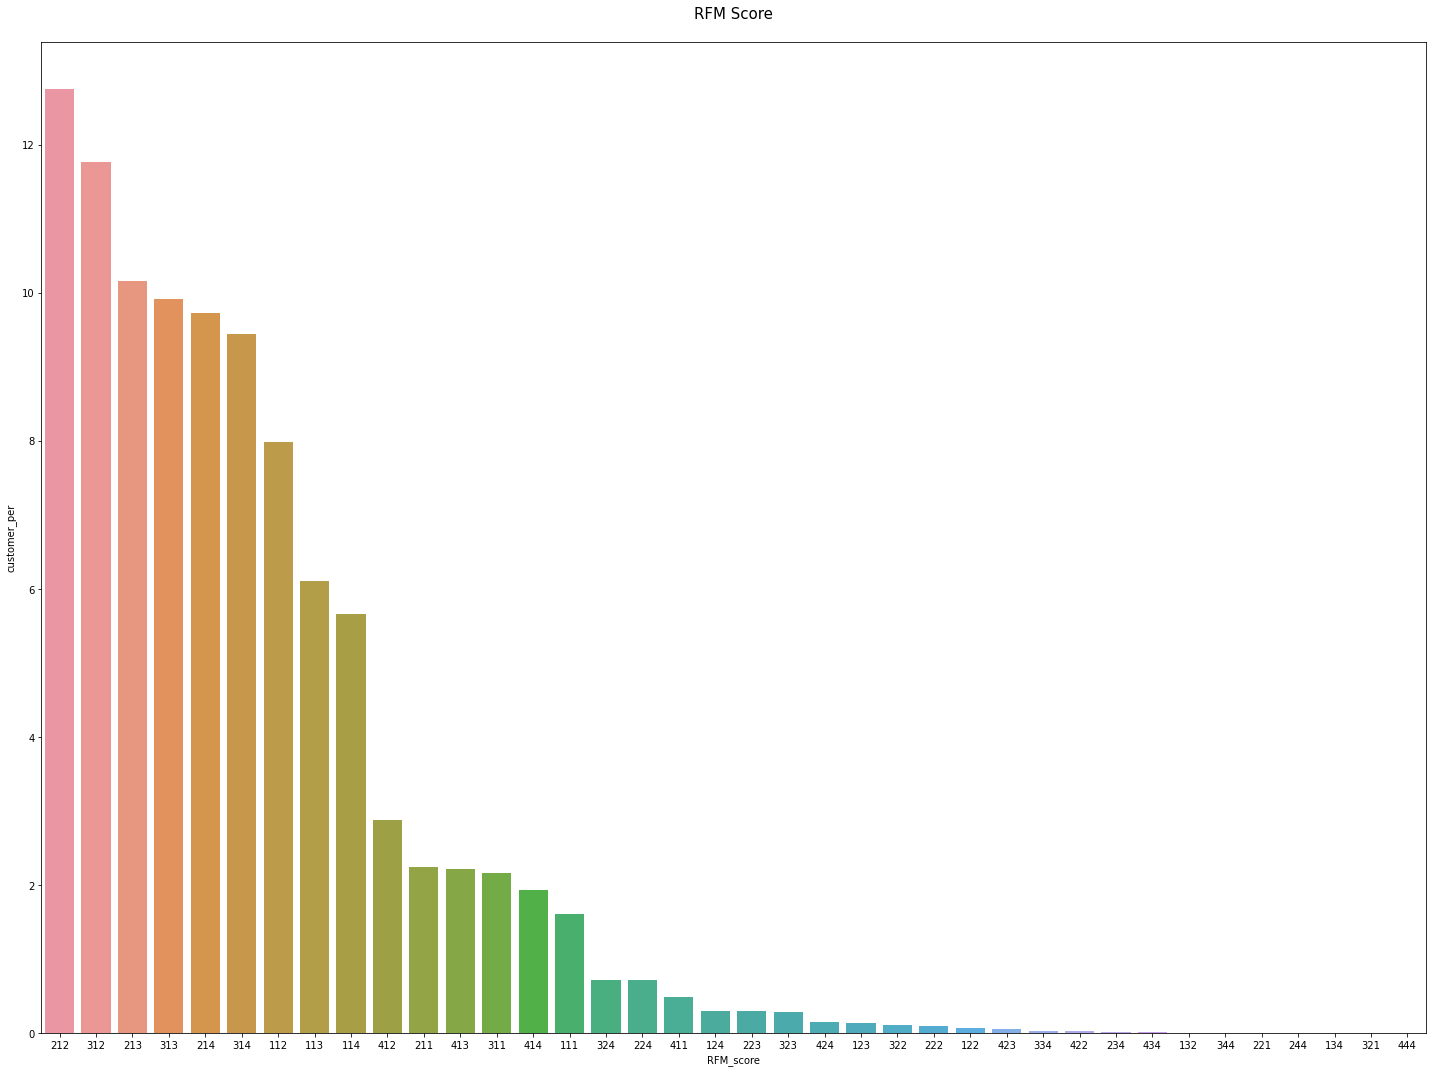

In [183]:
# Графическое представление распределения RFM_score
fig, ax = plt.subplots(figsize = (20, 15))
sns.barplot(data = rfm_count, x = 'RFM_score', y = 'customer_per')
ax.set_title('RFM Score\n', fontsize = 15)
plt.tight_layout()

Пользователи с идентификатором "111" совершали покупки давно (более года назад), всего один раз и на небольшую сумму (до 20). О таких клиентах можно не беспокоиться. Пользователи "444" делают покупки часто (более 6 раз), на значительные суммы (более 140), и их последняя покупка была недавно (в пределах месяца). Таких клиентов следует беречь и внимательно отслеживать изменения в их поведении. Пользователи "144", "244", "134", "133" и другие - это лояльные клиенты, которые утратили активность, и им стоит напомнить о себе.

Основная часть клиентов относится к группам RFM "212" и "312" (последняя покупка была от 1 до 6 месяцев назад, количество покупок - один, суммарный объем покупок составляет 20-70). Мы наблюдаем низкие показатели удержания клиентов и невысокий средний чек.

Лучшие клиенты с RFM "444" составляют примерно 0,01% от общего числа.

In [184]:
# Вычислим среднее значение метрик во всех сегментах и посмотрим на их распределение по сегментам
rfm_mean = rfm.groupby('RFM_score', as_index = False) \
    .agg({'R' : 'mean', 'F' : 'mean', 'M' : 'mean'})
rfm_mean.head()

,RFM_score,R,F,M
0,111,466.503989,1.000000,15.929009
1,112,463.546711,1.000000,46.200668
2,113,463.712403,1.000000,103.880295
3,114,466.593105,1.000000,334.718172
4,122,478.705882,2.058824,47.928676


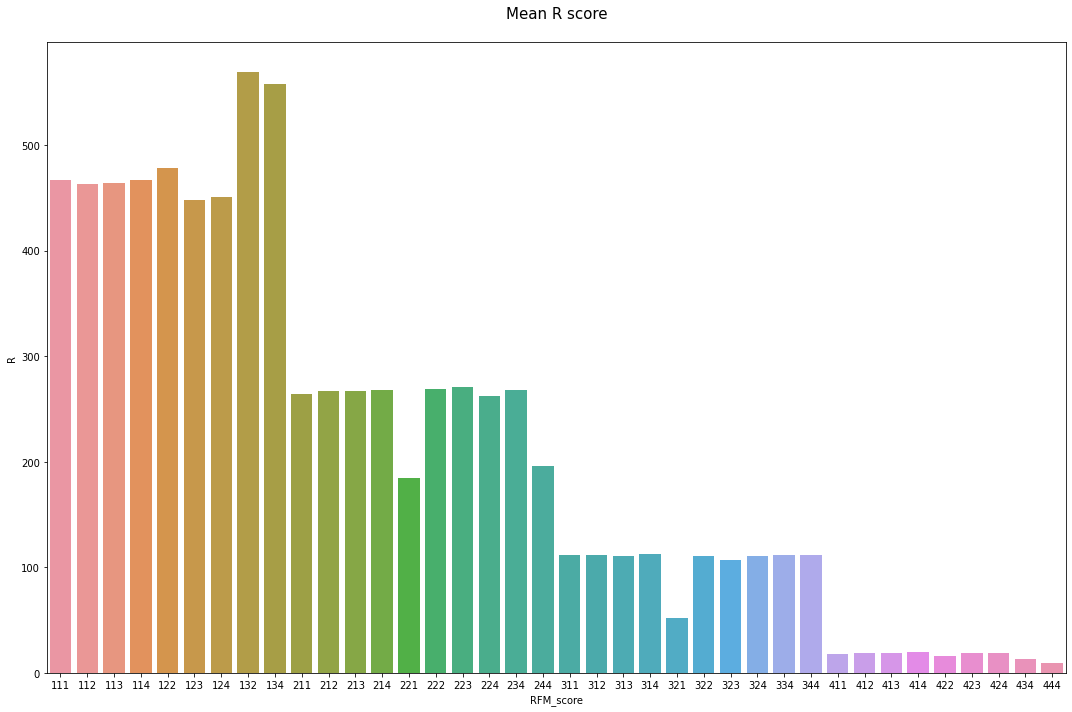

In [185]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.barplot(data = rfm_mean, x = 'RFM_score', y = 'R')
ax.set_title('Mean R score\n', fontsize = 15)
plt.tight_layout()

На графике наблюдается достаточно равномерное сокращение времени с момента последней покупки пользователя до текущей даты по мере увеличения первого числа сегмента (то есть, чем меньше количество дней, тем выше значение).

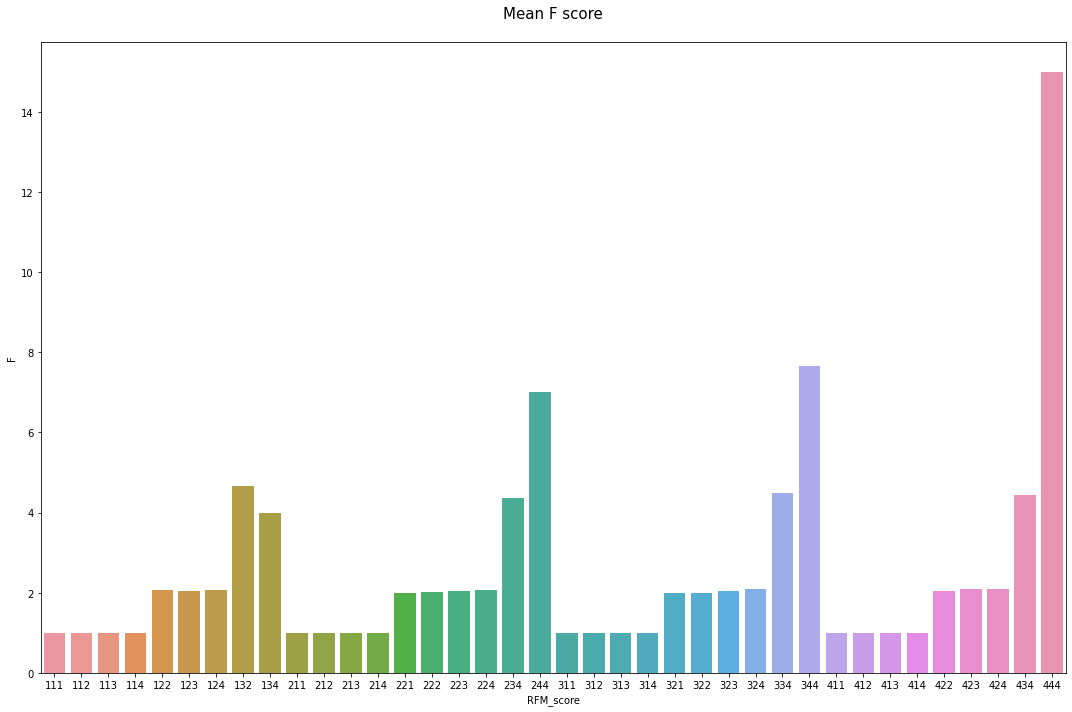

In [186]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.barplot(data = rfm_mean, x = 'RFM_score', y = 'F')
ax.set_title('Mean F score\n', fontsize = 15)
plt.tight_layout()

В данном случае второе число в оценке увеличивается, что придаёт графику ступенчатую форму. Наибольшее количество заказов зафиксировано у клиентов, которые совершали покупки очень давно.

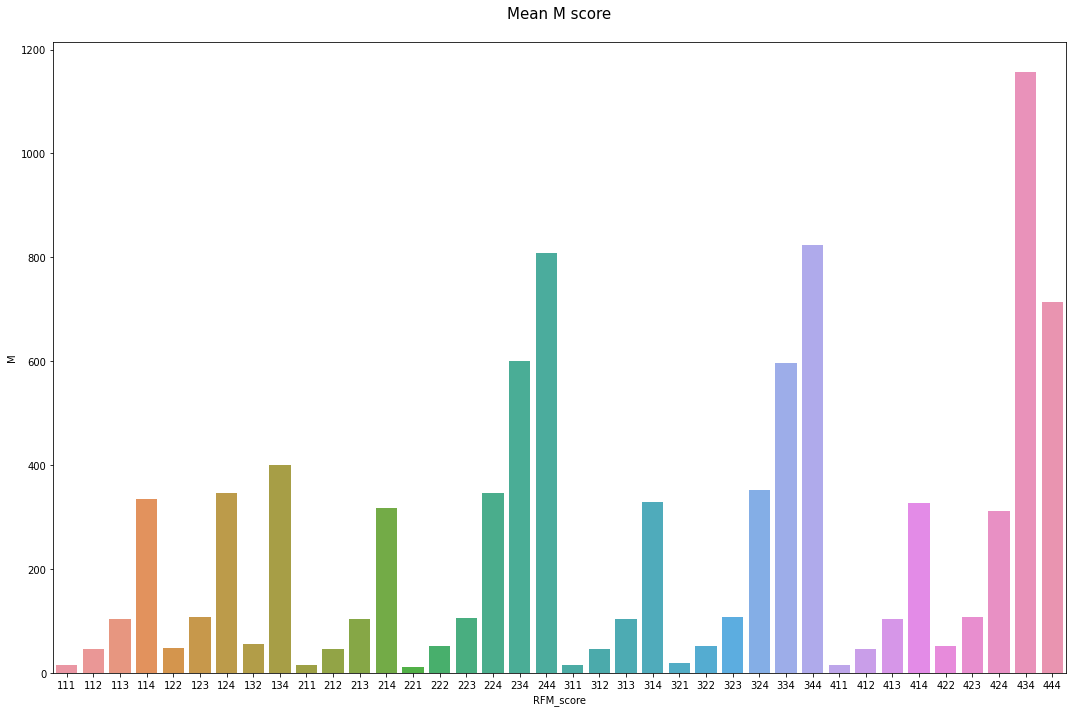

In [187]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.barplot(data = rfm_mean, x = 'RFM_score', y = 'M')
ax.set_title('Mean M score\n', fontsize = 15)
plt.tight_layout()

Здесь также можно заметить ступенчатую форму графика.